In [21]:
import os, json, pickle, numpy as np, matplotlib.pyplot as plt
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from google.colab import files

In [2]:
# Go to https://www.kaggle.com -> Account -> Create New API Token
# Upload kaggle.json file here
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bandarubhargavi26","key":"54e083adb311de2379362c8c67b6ba35"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# Download the Dataset
!kaggle datasets download -d ai4a-lab/comprehensive-soil-classification-datasets

Dataset URL: https://www.kaggle.com/datasets/ai4a-lab/comprehensive-soil-classification-datasets
License(s): CC-BY-NC-SA-4.0
 94% 461M/490M [00:01<00:00, 370MB/s]
100% 490M/490M [00:01<00:00, 440MB/s]


In [8]:
# Extract the files
with zipfile.ZipFile("comprehensive-soil-classification-datasets.zip", 'r') as zip_ref:
    zip_ref.extractall("soil_dataset")

In [9]:
# Check dataset
!ls soil_dataset

CyAUG-Dataset  Orignal-Dataset


In [10]:
# Path to your dataset folder
base_dir = "soil_dataset/CyAUG-Dataset"

In [11]:
CLASS_NAMES = [
    "Alluvial_Soil",
    "Arid_Soil",
    "Black_Soil",
    "Laterite_Soil",
    "Mountain_Soil",
    "Red_Soil",
    "Yellow_Soil"
]

In [12]:
# DATA PREPROCESSING
img_size = 128
batch_size = 32

In [13]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True
)

In [14]:
train_generator = datagen.flow_from_directory(
    base_dir,
    classes=CLASS_NAMES,                 # whitelist only these
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True,
    seed=42
)

Found 4080 images belonging to 7 classes.


In [15]:
val_generator = datagen.flow_from_directory(
    base_dir,
    classes=CLASS_NAMES,                 # MUST match above
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False,
    seed=42
)

Found 1016 images belonging to 7 classes.


In [16]:
print("Class indices (name -> index):", train_generator.class_indices)
labels_by_index = {v: k for k, v in train_generator.class_indices.items()}
print("Index -> label:", labels_by_index)

Class indices (name -> index): {'Alluvial_Soil': 0, 'Arid_Soil': 1, 'Black_Soil': 2, 'Laterite_Soil': 3, 'Mountain_Soil': 4, 'Red_Soil': 5, 'Yellow_Soil': 6}
Index -> label: {0: 'Alluvial_Soil', 1: 'Arid_Soil', 2: 'Black_Soil', 3: 'Laterite_Soil', 4: 'Mountain_Soil', 5: 'Red_Soil', 6: 'Yellow_Soil'}


In [23]:
# Build CNN Model
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(img_size, img_size, 3)),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation="softmax")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,543 (12.61 MB)

 Trainable params: 3,305,543 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# Train Model
history = model.fit(train_generator,validation_data=val_generator,epochs=25)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 41s 271ms/step - accuracy: 0.6519 - loss: 1.0202 - val_accuracy: 0.8415 - val_loss: 0.4593
Epoch 2/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 219ms/step - accuracy: 0.8769 - loss: 0.3728 - val_accuracy: 0.8297 - val_loss: 0.4367
Epoch 3/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 218ms/step - accuracy: 0.8887 - loss: 0.3511 - val_accuracy: 0.8189 - val_loss: 0.6154
Epoch 4/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 217ms/step - accuracy: 0.9155 - loss: 0.2588 - val_accuracy: 0.8366 - val_loss: 0.5026
Epoch 5/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 252ms/step - accuracy: 0.9028 - loss: 0.3028 - val_accuracy: 0.8406 - val_loss: 0.4903
Epoch 6/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 218ms/step - accuracy: 0.9261 - loss: 0.2273 - val_accuracy: 0.8071 - val_loss: 0.6326
Epoch 7/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 32s 253ms/step - accuracy: 0.9163 - loss: 0.2197 - val_accuracy: 0.8209 - val_loss: 0.6455
Epoch 8/25
128/128 ━━━━━━━━━━━━━━━━━━━━ 28s 217ms/step - accuracy: 0.9208 - loss: 0

In [27]:
loss, acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {acc*100:.2f}%")

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - accuracy: 0.7968 - loss: 0.8054
Validation Accuracy: 87.60%


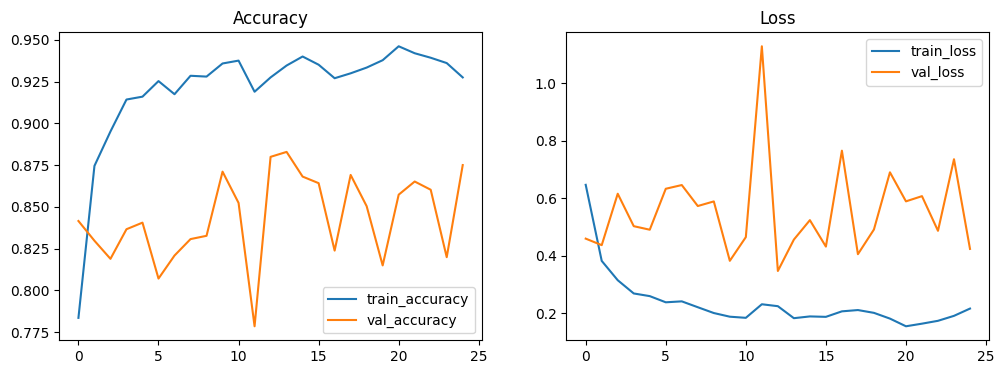

In [28]:
# Plot Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title("Loss")

plt.show()

In [29]:
# Save the models and lables
model.save("soil_cnn_model.h5")
with open("class_indices.pkl", "wb") as f:
    pickle.dump(train_generator.class_indices, f)
print("Saved: soil_cnn_model.h5 and class_indices.pkl")

Saved: soil_cnn_model.h5 and class_indices.pkl


In [30]:
# RELOAD model + labels
model = load_model("soil_cnn_model.h5")
with open("class_indices.pkl", "rb") as f:
    class_indices = pickle.load(f)
labels_by_index = {v:k for k, v in class_indices.items()}
print("Loaded labels:", labels_by_index)


Loaded labels: {0: 'Alluvial_Soil', 1: 'Arid_Soil', 2: 'Black_Soil', 3: 'Laterite_Soil', 4: 'Mountain_Soil', 5: 'Red_Soil', 6: 'Yellow_Soil'}


In [31]:
# UPLOAD image(s) & PREDICT

def predict_uploaded_images(img_target_size=(img_size, img_size)):
    uploaded = files.upload()  # choose one or more images
    for name in uploaded.keys():
        img = load_img(name, target_size=img_target_size)
        arr = img_to_array(img) / 255.0
        arr = np.expand_dims(arr, axis=0)

        probs = model.predict(arr)
        idx = int(np.argmax(probs, axis=1)[0])
        conf = float(np.max(probs))

        print(f"\nFile: {name}")
        print(f"Predicted: {labels_by_index[idx]}  |  Confidence: {conf*100:.2f}%")
        plt.imshow(load_img(name)); plt.axis("off"); plt.title(f"{labels_by_index[idx]} ({conf*100:.1f}%)")
        plt.show()


Saving arid soil.jpg to arid soil.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

File: arid soil.jpg
Predicted: Arid_Soil  |  Confidence: 96.83%


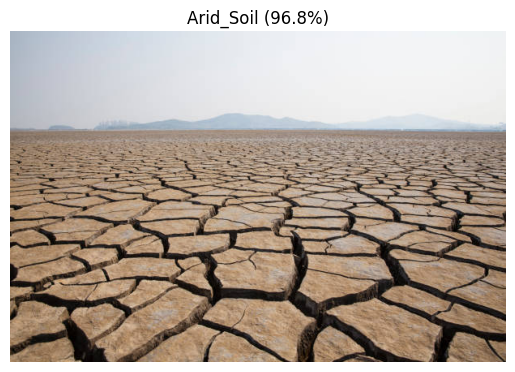

In [34]:
# Run prediction
predict_uploaded_images()